In [1]:
import glob
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics_to_use = ["accuracy", "relative_accuracy", "inference_time", "memory_use_GB", "disk_use_GB"]
metrics_to_use = ["student_model_name", "inference_speed", "student_memory", "student_num_params", "train_loss", "val_loss", "train_acc", "val_acc"]

In [2]:
json_files = glob.glob('./results/*.json')
json_file_names = [os.path.basename(file) for file in json_files]

print(json_file_names)

['mobilenet-V3-large-best-0.980918-lr;0.001-bs;256-weight_decay;0-T;8-loss_ratio;0.8.json', 'mobilenet-V3-large_best-0.9757621932029724_lr-0.001_bs-256_weight_decay-0_T-2_loss_ratio-0.5.json', 'mobilenet-V3-large_best-0.9829496932029724_lr-0.001_bs-256_weight_decay-0_T-4_loss_ratio-0.5.json', 'mobilenet-V3-large_best-0.9829687476158142_lr-0.001_bs-256_weight_decay-0_T-6_loss_ratio-0.5.json', 'mobilenet-V3-small-best-0.975918-lr;0.001-bs;256-weight_decay;0-T;8-loss_ratio;0.8.json', 'mobilenet-V3-small_best-0.9733993887901307_lr-0.001_bs-256_weight_decay-0_T-2_loss_ratio-0.5.json', 'mobilenet-V3-small_best-0.9762499976158142_lr-0.001_bs-256_weight_decay-0_T-4_loss_ratio-0.5.json', 'mobilenet-V3-small_best-0.9771108128586594_lr-0.001_bs-128_weight_decay-0_T-1_loss_ratio-0.json', 'mobilenet-V3-small_best-0.9771684432029724_lr-0.001_bs-256_weight_decay-0_T-6_loss_ratio-0.5.json', 'teacher_model_num_epochs-2_lr-0.001_bs-64_weight_decay-0.0001_data_dir-real_data_n_classes-4_T-0.8_loss_ratio-0

In [3]:
json_data = []

for file in json_files:
    with open(file, 'r') as json_file:
        if "teacher" not in file:
            data = json.load(json_file)
            json_data.append(data)
        else:
            teacher_data = json.load(json_file)


In [4]:
# teacher_data

In [5]:
teacher_data["student_model_name"] = "teacher model"
teacher_data["train_loss"] = None
teacher_data["train_acc"] = None
teacher_data["inference_speed"] = teacher_data["inference_speed"][0]
teacher_data["val_loss"] = teacher_data["val_loss"][0]
teacher_data["val_acc"] = teacher_data["val_acc"][0]
teacher_data = [{key: teacher_data[key] for key in metrics_to_use}]
teacher_data

[{'student_model_name': 'teacher model',
  'inference_speed': 8.445559740066528,
  'student_memory': 512.2214508056641,
  'student_num_params': 134275780,
  'train_loss': None,
  'val_loss': 1.327368676662445,
  'train_acc': None,
  'val_acc': 0.8723958432674408}]

In [6]:
# json_data

In [7]:
json_data = [{key: report[key] for key in metrics_to_use} for report in json_data]
# json_data

In [8]:
# Calculate averages
for report in json_data:
    for key, value in report.items():
        if isinstance(value, list):
            # If the value is a list, calculate the average
            avg = sum(value) / len(value)
            report[key] = avg

json_data

[{'student_model_name': 'mobilenet-V3-large',
  'inference_speed': 21.515641605854036,
  'student_memory': 16.1424560546875,
  'student_num_params': 4207156,
  'train_loss': 0.6937498498898073,
  'val_loss': 10.879592657625675,
  'train_acc': 0.982680741591113,
  'val_acc': 0.8227303718924521},
 {'student_model_name': 'mobilenet-V3-large',
  'inference_speed': 57.94958718121052,
  'student_memory': 16.1424560546875,
  'student_num_params': 4207156,
  'train_loss': 0.10480248899144425,
  'val_loss': 1.4660763854673133,
  'train_acc': 0.9817506266491753,
  'val_acc': 0.7724404522776604},
 {'student_model_name': 'mobilenet-V3-large',
  'inference_speed': 16.745843636989594,
  'student_memory': 16.1424560546875,
  'student_num_params': 4207156,
  'train_loss': 0.20647401861200226,
  'val_loss': 2.795055589005351,
  'train_acc': 0.9855721194829259,
  'val_acc': 0.8241415761709213},
 {'student_model_name': 'mobilenet-V3-large',
  'inference_speed': 5.002408504486084,
  'student_memory': 16.1

In [9]:
full_json = (teacher_data + json_data)

In [10]:
df = pd.DataFrame(full_json)
df["student_model_name"] = df["student_model_name"] + df.index.astype(str)
df['student_num_params'] = df['student_num_params'] / 1e6
df["relative_val_loss"] = df["val_loss"] / teacher_data[0]["val_loss"]
df["relative_val_acc"] = df["val_acc"] / teacher_data[0]["val_acc"]

print(df)

df_melted_model = pd.melt(df, id_vars=["student_model_name"], var_name="metric", value_name="value")

    student_model_name  inference_speed  student_memory  student_num_params  \
0       teacher model0         8.445560      512.221451          134.275780   
1  mobilenet-V3-large1        21.515642       16.142456            4.207156   
2  mobilenet-V3-large2        57.949587       16.142456            4.207156   
3  mobilenet-V3-large3        16.745844       16.142456            4.207156   
4  mobilenet-V3-large4         5.002409       16.142456            4.207156   
5  mobilenet-V3-small5        21.290334        5.852264            1.521956   
6  mobilenet-V3-small6        51.690565        5.852264            1.521956   
7  mobilenet-V3-small7        72.403278        5.852264            1.521956   
8  mobilenet-V3-small8        19.277613        5.852264            1.521956   
9  mobilenet-V3-small9        62.637822        5.852264            1.521956   

   train_loss   val_loss  train_acc   val_acc  relative_val_loss  \
0         NaN   1.327369        NaN  0.872396           1.0000

In [11]:
# # Create a bar plot for student_num_params
# plt.barh(df['student_model_name'], df['student_num_params'], color='b', alpha=0.5)
# plt.xlabel('student_num_params (in millions)')
# plt.ylabel('student_model_name')
# plt.show()

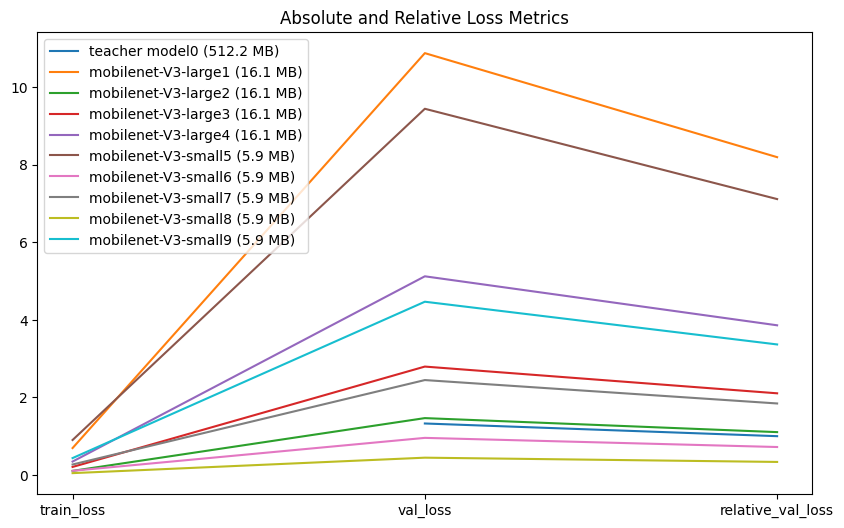

In [12]:
# Define the metrics and model names
metrics = ['train_loss', 'val_loss', 'relative_val_loss']
model_names = df['student_model_name'].unique()

# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the absolute loss metrics
for model in model_names:
    values = df[df['student_model_name'] == model][['train_loss', 'val_loss', 'relative_val_loss']].values.flatten()
    ax1.plot(metrics, values, label=f"{model} ({df[df['student_model_name'] == model]['student_memory'].values[0]:.1f} MB)")

# Add a legend and a title
ax1.legend(loc='upper left')
plt.title('Absolute and Relative Loss Metrics')

plt.savefig('images/losses.png')
plt.show()


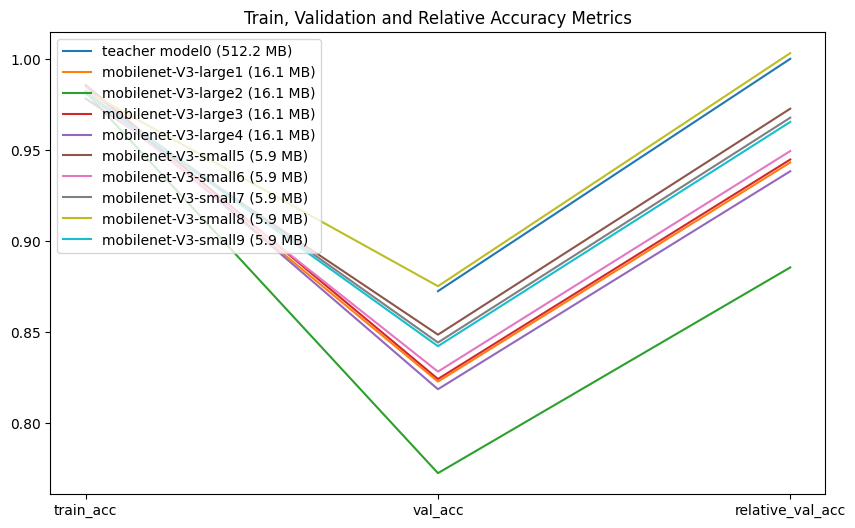

In [13]:
# Define the metrics and model names
metrics = ['train_acc', 'val_acc', 'relative_val_acc']
model_names = df['student_model_name'].unique()

# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))
# sns.set_style("darkgrid")

# Plot the accuracy metrics
for model in model_names:
    values = df[df['student_model_name'] == model][metrics].values.flatten()
    ax1.plot(metrics, values, label=f"{model} ({df[df['student_model_name'] == model]['student_memory'].values[0]:.1f} MB)")

# Add a legend and a title
ax1.legend(loc='upper left')
plt.title('Train, Validation and Relative Accuracy Metrics')

plt.savefig('images/accs.png')
plt.show()


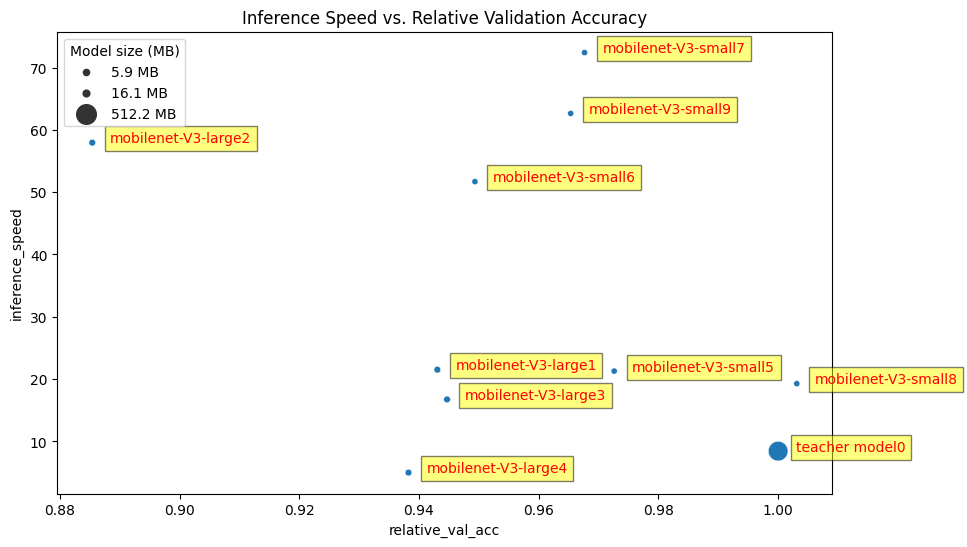

In [14]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='relative_val_acc', y='inference_speed', size='student_memory', sizes=(20, 200))

# Add model names as text annotations
for i in range(df.shape[0]):
    plt.text(x=df['relative_val_acc'].iloc[i]+0.003, 
             y=df['inference_speed'].iloc[i], 
             s=df['student_model_name'].iloc[i], 
             fontdict=dict(color='red',size=10),
             bbox=dict(facecolor='yellow',alpha=0.5))

# Modify the legend to round sizes and add a title
handles, labels = scatter.get_legend_handles_labels()
labels = [f'{round(float(label), 1)} MB' for label in labels]
plt.legend(handles, labels, title='Model size (MB)', loc=2)

plt.title('Inference Speed vs. Relative Validation Accuracy')
plt.savefig('images/fat_plot.png')
plt.show()


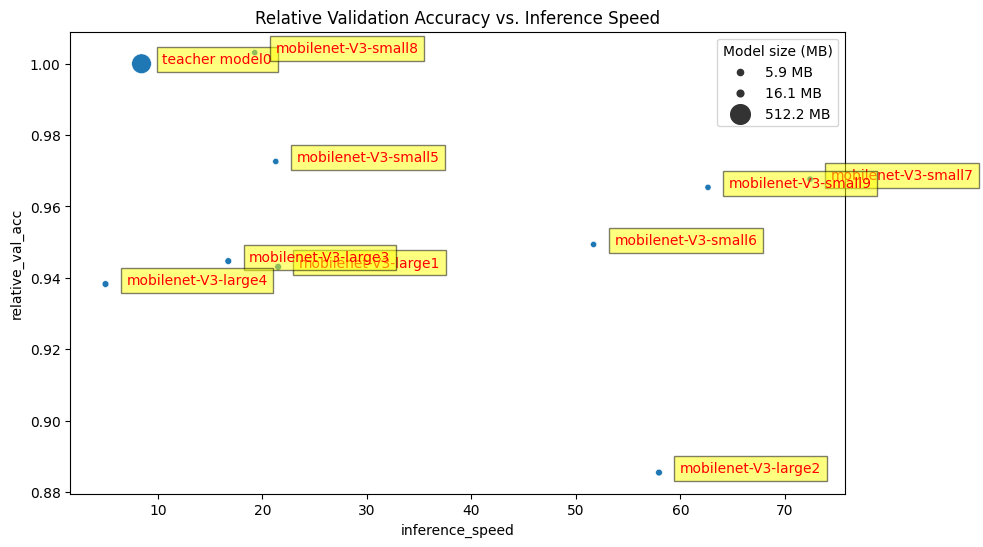

In [22]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='inference_speed', y='relative_val_acc', size='student_memory', sizes=(20, 200))

# Add model names as text annotations
for i in range(df.shape[0]):
    plt.text(x=df['inference_speed'].iloc[i]+2, 
             y=df['relative_val_acc'].iloc[i], 
             s=df['student_model_name'].iloc[i], 
             fontdict=dict(color='red',size=10),
             bbox=dict(facecolor='yellow',alpha=0.5))

# Modify the legend to round sizes and add a title
handles, labels = scatter.get_legend_handles_labels()
labels = [f'{round(float(label), 1)} MB' for label in labels]
plt.legend(handles, labels, title='Model size (MB)')

plt.title('Relative Validation Accuracy vs. Inference Speed')
plt.savefig('images/fat_plot.png')
plt.show()
